In [1]:
# Import necessary PyTorch and related libraries
import torch                             # Main PyTorch library
import torch.nn as nn                    # For building neural network layers
import torch.optim as optim              # For optimization algorithms like SGD, Adam
import torchvision.transforms as transforms   # For image transformations (e.g., resize, normalize)
from torchvision.datasets import ImageFolder  # For loading images arranged in folders
from torch.utils.data import DataLoader, random_split  # For data loading and splitting

# Import pre-trained models and weights
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights  # Import ResNet50 model and its default weights

# Other useful libraries
import numpy as np                      # For numerical operations
import matplotlib.pyplot as plt         # For plotting (used for visualizing training, images, etc.)
import seaborn as sns                   # For better visualizations (like confusion matrices)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Metrics to evaluate model performance

from PIL import Image                   # For image handling
import random                           # For generating random numbers

# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)                # Set seed for PyTorch
np.random.seed(seed)                   # Set seed for NumPy
random.seed(seed)                      # Set seed for Python's random module

In [2]:
# Define a set of image transformations to apply to the training data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 (input size for ResNet)
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize based on ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Define a transformation for testing data
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize (same as training)
                         std=[0.229, 0.224, 0.225])
])

# Define paths to the training and testing datasets
train_dir = "dataset/Training"
test_dir = "dataset/Testing"

# Load the training dataset with transformation applied
full_dataset = ImageFolder(root=train_dir, transform=transform_train)

# Load the test dataset with testing transformations
test_dataset = ImageFolder(root=test_dir, transform=transform_test)

# Split the training dataset into training and validation sets (80% training, 20% validation)
val_size = int(0.2 * len(full_dataset))  # 20% for validation
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Set batch size for loading data
batch_size = 64

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)      # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    # No shuffle for testing

# Print class-to-index mapping (e.g., {'glioma': 0, ......
print("Class mapping:", full_dataset.class_to_idx)


Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


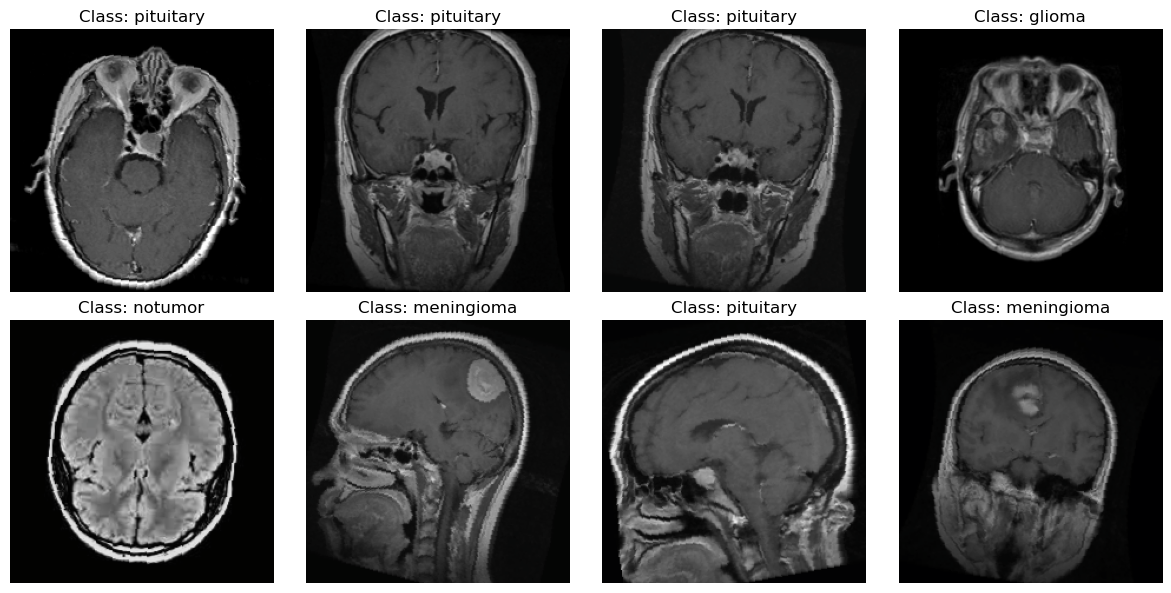

In [3]:
# Function to reverse the normalization so we can view the image properly
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # Mean used during normalization
    std = np.array([0.229, 0.224, 0.225])   # Std used during normalization
    img = img.numpy().transpose((1, 2, 0))  # Change from [C, H, W] to [H, W, C] for matplotlib
    img = img * std + mean                 # Undo normalization
    img = np.clip(img, 0, 1)               # Make sure pixel values are within [0, 1]
    return img

# Get one batch of images and their labels from the training DataLoader
images, labels = next(iter(train_loader))

# Number of images to display
num_images = 8
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Create a 2x4 grid of subplots

# Loop through the first 8 images
for i in range(num_images):
    ax = axes[i // 4, i % 4]                   # Position the subplot (2 rows, 4 columns)
    ax.imshow(denormalize(images[i]))         # Show the image after denormalizing it
    ax.set_title(f"Class: {full_dataset.classes[labels[i]]}")  # Show class name as title
    ax.axis("off")                            # Hide the axis ticks and labels

plt.tight_layout()  # Adjust spacing between subplots for better layout
plt.show()          # Display the figure


In [4]:
# Choose device: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ResNet-50 model with default ImageNet weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers (no training for them)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected (fc) layer to match the number of classes in your dataset (4 in this case)
num_ftrs = model.fc.in_features              # Get input features to the fc layer
model.fc = nn.Linear(num_ftrs, 4)            # Replace with a new fc layer for 4 classes

# Move the model to GPU or CPU
model = model.to(device)

# Define the loss function — CrossEntropyLoss is used for multi-class classification
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer, but only update parameters of the new fc layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Set up a learning rate scheduler that reduces the LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, verbose=True
)


D:\all\anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# Training parameters
num_epochs = 50        # Max number of epochs to train
patience = 7           # Early stopping patience (stop if no improvement in val loss after 7 epochs)
best_loss = np.inf     # Track best validation loss
counter = 0            # Counts epochs with no improvement

# Lists to store metrics over epochs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = []
lr_list = []           # To track learning rate over time

# Start training loop
for epoch in range(num_epochs):
    model.train()       # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Train on batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()               # Clear gradients
        outputs = model(images)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Update parameters

        running_loss += loss.item()         # Accumulate batch loss
        _, predicted = torch.max(outputs, 1)            # Get predicted class
        correct += (predicted == labels).sum().item()   # Count correct predictions
        total += labels.size(0)                         # Count total samples

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase 
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Track learning rate
    lr_list.append(optimizer.param_groups[0]['lr'])

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping and saving best model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_resnet50.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break  # Stop training if no improvement for `patience` epochs


Epoch [1/50], Train Loss: 0.8837, Val Loss: 0.6647, Val Acc: 0.8266
Epoch [2/50], Train Loss: 0.5591, Val Loss: 0.4892, Val Acc: 0.8581
Epoch [3/50], Train Loss: 0.4726, Val Loss: 0.4364, Val Acc: 0.8660
Epoch [4/50], Train Loss: 0.4204, Val Loss: 0.3762, Val Acc: 0.8870
Epoch [5/50], Train Loss: 0.3913, Val Loss: 0.3466, Val Acc: 0.8967
Epoch [6/50], Train Loss: 0.3775, Val Loss: 0.3537, Val Acc: 0.9072
Epoch [7/50], Train Loss: 0.3475, Val Loss: 0.3346, Val Acc: 0.8923
Epoch [8/50], Train Loss: 0.3291, Val Loss: 0.3140, Val Acc: 0.8975
Epoch [9/50], Train Loss: 0.3183, Val Loss: 0.3108, Val Acc: 0.8967
Epoch [10/50], Train Loss: 0.3191, Val Loss: 0.3004, Val Acc: 0.9089
Epoch [11/50], Train Loss: 0.3092, Val Loss: 0.3031, Val Acc: 0.8967
Epoch [12/50], Train Loss: 0.2998, Val Loss: 0.2682, Val Acc: 0.9081
Epoch [13/50], Train Loss: 0.2904, Val Loss: 0.2804, Val Acc: 0.9124
Epoch [14/50], Train Loss: 0.2865, Val Loss: 0.2644, Val Acc: 0.9081
Epoch [15/50], Train Loss: 0.2704, Val Loss

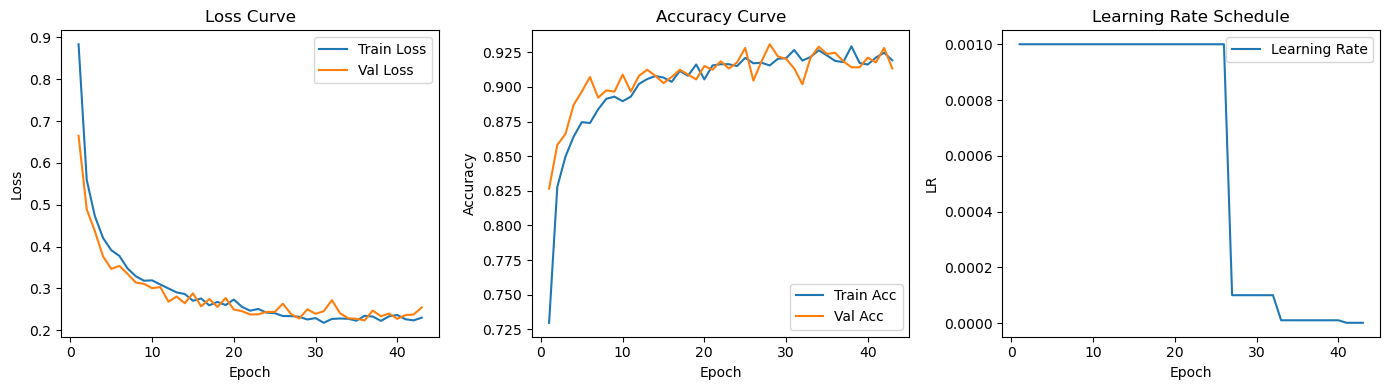

In [6]:
# Create a range of epoch numbers to use for the x-axis
epochs = range(1, len(train_losses)+1)

# Create a wide figure with 3 subplots
plt.figure(figsize=(14, 4))

# --- Subplot 1: Loss Curve ---
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')  # Training loss per epoch
plt.plot(epochs, val_losses, label='Val Loss')      # Validation loss per epoch
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# --- Subplot 2: Accuracy Curve ---
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')  # Training accuracy per epoch
plt.plot(epochs, val_accuracies, label='Val Acc')      # Validation accuracy per epoch
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

# --- Subplot 3: Learning Rate Schedule ---
plt.subplot(1, 3, 3)
plt.plot(epochs, lr_list, label='Learning Rate')  # Learning rate per epoch
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Set device for computation (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for test data (resize, tensor conversion, and normalization)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to match ResNet's pre-trained weights
])


In [3]:
# Load the test dataset using ImageFolder and apply transformations
test_dir = "dataset/Testing"
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Create DataLoader for batch processing of test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print class names to confirm class structure in the test set
class_names = test_dataset.classes
print("Class Names:", class_names)


Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
# Load ResNet50 model with pre-trained weights from ImageNet
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers to prevent retraining
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes (4 in this case)
model.fc = nn.Linear(model.fc.in_features, 4)

# Load the saved best model weights (saved earlier)
model.load_state_dict(torch.load("best_resnet50.pth", map_location=device))

# Move the model to the appropriate device (GPU/CPU)
model = model.to(device)

# Set model to evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for inference to save memory and computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions from the model
        outputs = model(images)
        
        # Get predicted class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics: accuracy, precision, recall, and F1 score
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Accuracy: 95.26%
Precision: 0.9528
Recall: 0.9526
F1 Score: 0.9526


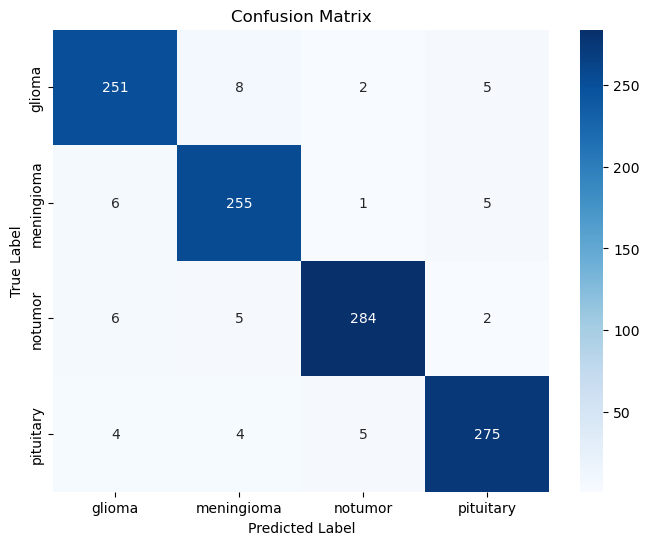

In [6]:
# Calculate the confusion matrix based on true and predicted labels
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Set axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()
